In [6]:
# CS 8803 Efficient Machine Learning
# Tanush Chopra
# GT ID: 903785867
# Date: 10/18/2025
#
# Lab 02: Quantization
#
# This lab will guide you through the fundamental concepts of model quantization,
# including uniform, non-uniform, and quantization-aware training (QAT).
# You will implement these techniques from scratch and apply them to a
# pretrained OPT-125m language model.

# Lab Overview and Instructions

In this lab, we will explore quantization with the OPT-125m model and WikiText-2 dataset to understand the basics of quantization and its implications on model performance and efficiency.

### Grading
The lab is divided into six main tasks with the following point distribution:
-   **Task 1: Setup and Baseline (15%)**
-   **Task 2: Uniform Quantization Implementation (20%)**
-   **Task 3: Non-Uniform (Power-of-Two) Quantization (10%)**
-   **Task 4: Applying and Analyzing Quantization (20%)**
-   **Task 5: Quantization-Aware Training (QAT) (20%)**
-   **Task 6: Advanced Quantization (15%)**

### Deliverables
You are required to submit this completed Jupyter Notebook. Ensure that you have:
1.  Filled in all the `#TODO` sections with functional code.
2.  Generated all the required plots and dataframes.
3.  Written your answers and analysis in the designated markdown cells.


# Task 1: Setup and Baseline [15%]

### Part 1a: Download the Dataset and Model [2.5%]

**Task:** Your first step is to set up the environment by loading the necessary model and dataset. You will use the Hugging Face `transformers` library to download the `facebook/opt-125m` model and the `datasets` library to load the `wikitext` dataset.

-   **Model:** `facebook/opt-125m` is a small, decoder-only transformer model, suitable for experimentation without requiring heavy GPU usage.
-   **Dataset:** `wikitext-2-raw-v1` is a standard language modeling benchmark dataset. We will use the 'train' and 'test' splits.

In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import torch.nn.functional as F
import gc
from dataclasses import dataclass
from torch.autograd import Function

# --- 1. Model and Tokenizer Setup ---
model_name = "facebook/opt-125m"

# TODO: Load the tokenizer for the specified model.

tokenizer = AutoTokenizer.from_pretrained(model_name)

# OPT models don't have a default padding token, so we set it to the EOS (End Of Sentence) token.
# This is important for batching inputs of different lengths.
tokenizer.pad_token = tokenizer.eos_token

device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: Load the pre-trained causal language model.
# Ensure the model is moved to the correct device
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# --- 2. Load the dataset ---
# We'll use the 'wikitext-2-raw-v1' version of the wikitext dataset.

# TODO: Load the 'test' split for final evaluation.
test_dataset = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1", split="test")

# TODO: Load the 'train' split, which we will use for QAT.
train_dataset = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1", split="train")

/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# DO NOT MODIFY THIS CELL

# This cell contains helper functions to tokenize and prepare the data for evaluation.

def tokenize_and_chunk(texts, tokenizer, seq_length=512):
    """Tokenizes text and splits it into fixed-length chunks."""
    all_tokens = tokenizer(
        "\n\n".join(texts),
        return_tensors="pt",
        truncation=False,
    ).input_ids.squeeze()
    data_chunks = []
    for i in range(0, all_tokens.size(0) - seq_length, seq_length):
        data_chunks.append(all_tokens[i : i + seq_length])
    return data_chunks

class PerplexityDataset(torch.utils.data.Dataset):
    """A torch Dataset for perplexity evaluation."""
    def __init__(self, chunks):
        self.chunks = chunks
    def __len__(self):
        return len(self.chunks)
    def __getitem__(self, idx):
        return self.chunks[idx]

# Create dataloaders for evaluation and training
eval_data_chunks = tokenize_and_chunk(test_dataset["text"], tokenizer, seq_length=512)
eval_dataset = PerplexityDataset(eval_data_chunks)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

train_subset_size = 512
train_data_chunks = tokenize_and_chunk(train_dataset["text"][: (train_subset_size * 2)], tokenizer, seq_length=512)
train_data_chunks = train_data_chunks[:train_subset_size]
train_p_dataset = PerplexityDataset(train_data_chunks)
train_dataloader = DataLoader(train_p_dataset, batch_size=8, shuffle=True)

### Part 1b: Establish Full-Precision Baseline [2.5%]

**Task:** Evaluate the original, full-precision (FP32) model to establish a baseline. We will use **perplexity** as our primary metric. Answer the following question for credit.


**Question:** What is perplexity?

Perplexity is a way to measure how well a language model predicts text. It basically shows how “confused” the model is — lower perplexity means the model is more confident and accurate. It’s calculated from the average loss, so a smaller value means the model is doing a better job at guessing the next words. In short, the lower the perplexity, the better the model’s performance.

In [9]:
# Run this cell to evaluate the full precision model
# DO NOT MODIFY THIS CELL
# This function for evaluating perplexity is provided for you.

def evaluate_perplexity(model, dataloader, device):
    model.eval()
    total_nll = 0.0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Perplexity"):
            input_ids = batch.to(device)
            num_tokens_in_batch = input_ids.numel()

            outputs = model(input_ids, labels=input_ids)

            total_nll += outputs.loss.item() * num_tokens_in_batch
            total_tokens += num_tokens_in_batch

    avg_nll = total_nll / total_tokens
    perplexity = torch.exp(torch.tensor(avg_nll))

    return avg_nll, perplexity.item()


# --- Calculate baseline perplexity ---
loss_fp, ppl_fp = evaluate_perplexity(model, eval_dataloader, device)
print(f"Full precision model: loss {loss_fp:.3f}, perplexity {ppl_fp:.3f}")

Calculating Perplexity: 100%|██████████| 71/71 [00:04<00:00, 14.47it/s]

Full precision model: loss 3.651, perplexity 38.517


### Part 1c: Analyze Model Size and Weight Distribution [10%]

**Task:** Before quantizing, it's important to understand the model's structure and size. You will implement helper functions to count model parameters and estimate the memory footprint after quantization.

In [10]:
# Print the model architecture to understand its layers.
print(model)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [11]:
# --- Helper functions to analyze model size ---

def count_params(module: nn.Module):
    """
    Counts the total number of parameters in a given PyTorch module.

    Input:
        module (nn.Module): The module to analyze.
    Output:
        int: The total number of parameters.
    """
    return sum(p.numel() for p in module.parameters())

def estimated_weight_size_bytes(m: nn.Module, w_bits=8):
    """
    Estimates the memory size of a model's weights after quantization.
    This function assumes biases are kept in 32-bit floating point.

    Inputs:
        m (nn.Module): The model.
        w_bits (int): The number of bits for quantized weights.
    Output:
        int: The estimated total size of the weights in bytes.
    """
    total_bytes = 0
    for module in m.modules():
        if not isinstance(module, nn.Linear):
            continue
        total_bytes += (module.weight.numel() * w_bits + 7) // 8
        if module.bias is not None:
            total_bytes += module.bias.numel() * 4
    return total_bytes


# Get the first OPT decoder layer parameters
first_decoder_layer = model.model.decoder.layers[0]

In [12]:
print(first_decoder_layer)

OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [13]:
description = []
for name, module in first_decoder_layer.named_children():
    if not isinstance(module, nn.Linear):
        continue
    description.append(f"{name}: {module} [{count_params(module)} params, {estimated_weight_size_bytes(module)} bytes]")
print("\n".join(description))

fc1: Linear(in_features=768, out_features=3072, bias=True) [2362368 params, 2371584 bytes]
fc2: Linear(in_features=3072, out_features=768, bias=True) [2360064 params, 2362368 bytes]


#### Visualize Weight Ranges and Granularity

**Task:** Visualize the weight ranges (minimum and maximum values) for the `fc1` layer in the first decoder block of the model. This analysis helps understand why finer-grained quantization can reduce error. You will compare three different **quantization granularities**:

1.  **Per-Tensor:** One min/max value for the entire weight matrix.
2.  **Per-Channel:** One min/max value for each output channel (i.e., each row).
3.  **Per-Group:** One min/max value for small groups of weights within each channel.

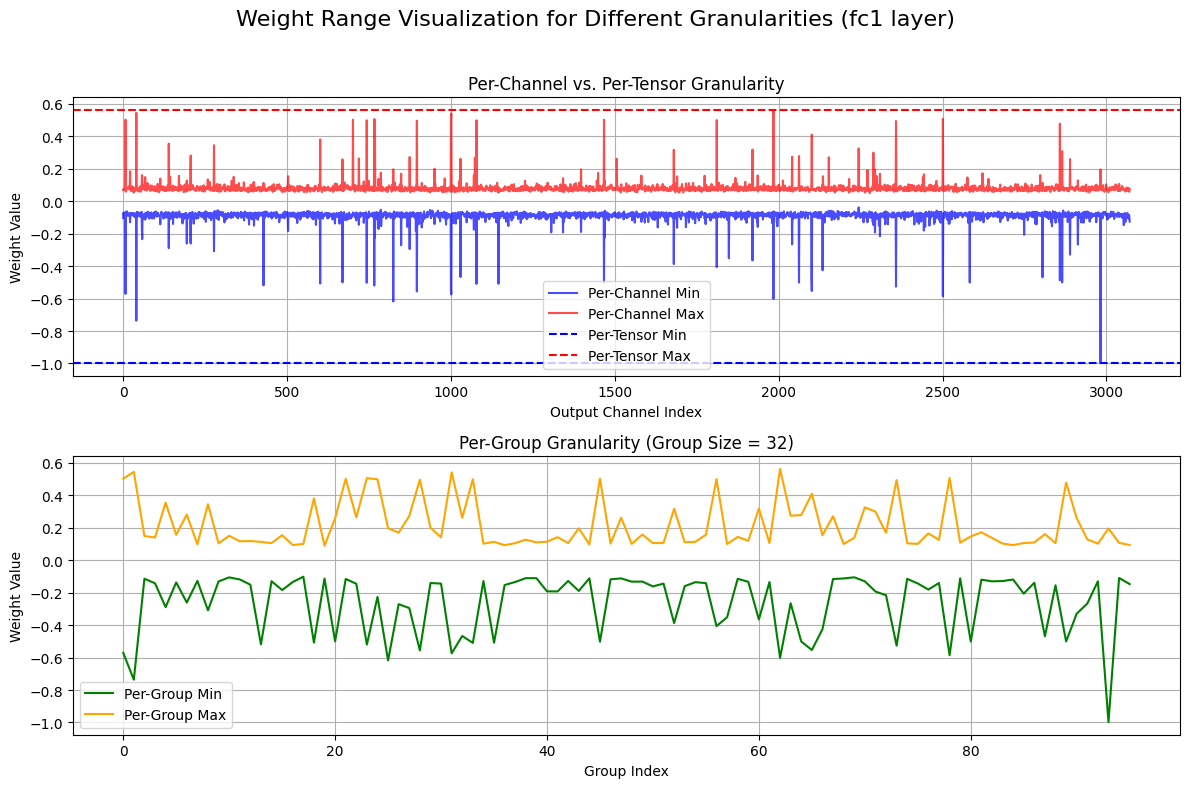

In [14]:
# --- Visualize the weight ranges (min/max) for the fc1 Linear layer ---

# 1. Get the weight tensor from the first fc1 layer
fc1_layer = model.model.decoder.layers[0].fc1
W = fc1_layer.weight.detach().cpu()

# TODO: Calculate per-tensor min/max
per_tensor_min = W.min().item()
per_tensor_max = W.max().item()

# TODO: Calculate per-channel min/max
# For a linear layer weight (out_features, in_features), the channel axis is 0.
per_channel_min = W.min(dim=1).values
per_channel_max = W.max(dim=1).values

# TODO: Calculate per-group min/max
group_size = 32
W_grouped = W.view(W.shape[0] // group_size, group_size, W.shape[1])
per_group_min = W_grouped.min(dim=1).values.min(dim=1).values
per_group_max = W_grouped.max(dim=1).values.max(dim=1).values

# --- Plotting --- (This code is provided for you)
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
fig.suptitle("Weight Range Visualization for Different Granularities (fc1 layer)", fontsize=16)

axs[0].plot(per_channel_min.numpy(), label='Per-Channel Min', color='blue', alpha=0.7)
axs[0].plot(per_channel_max.numpy(), label='Per-Channel Max', color='red', alpha=0.7)
axs[0].axhline(per_tensor_min, ls='--', color='blue', label='Per-Tensor Min')
axs[0].axhline(per_tensor_max, ls='--', color='red', label='Per-Tensor Max')
axs[0].set_title("Per-Channel vs. Per-Tensor Granularity")
axs[0].set_xlabel("Output Channel Index")
axs[0].set_ylabel("Weight Value")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(per_group_min.numpy(), label='Per-Group Min', color='green')
axs[1].plot(per_group_max.numpy(), label='Per-Group Max', color='orange')
axs[1].set_title(f"Per-Group Granularity (Group Size = {group_size})")
axs[1].set_xlabel("Group Index")
axs[1].set_ylabel("Weight Value")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Question:** Based on the visualization, explain how finer granularity (like per-channel or per-group) can reduce quantization error compared to per-tensor quantization.

From the plot, per-tensor quantization uses one big range for all weights (the dashed lines), while per-channel and per-group each get their own smaller range that better fits their actual values. Since different channels have very different min and max weights, a single per-tensor range has to stretch to cover outliers, which makes smaller values lose precision. Per-channel and per-group fix this by letting each subset of weights have its own scale, so the quantization steps are tighter and better match the real data. This helps keep more detail and reduces quantization error overall.

# Task 2: Uniform Quantization Implementation [20%]

### Part 2a: Implement Uniform Quantization Logic [20%]

**Task:** You will now implement the core logic for uniform quantization. This involves calculating scale factors and zero-points, and then using them to map high-precision floating-point numbers to lower-precision integers.

You will use the **Straight-Through Estimator (STE)** to allow gradients to pass through the non-differentiable `round` function, which is crucial for quantization-aware training later.

#### Hint:
-   **Affine (Asymmetric):** Maps values to $[q_{\min}, q_{\max}]$.
    
-   **Symmetric:** Maps values to $[-(2^{b-1}), 2^{b-1}-1]$.
    

In [15]:
# STE function (provided)
class _STERound(Function):
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

ste_round = _STERound.apply

# Quantization configuration (provided)
@dataclass
class QuantConfig:
    num_bits: int = 8
    symmetric: bool = True
    per_channel: bool = False
    channel_axis: int = 0
    group_size: int = None

# Helper for getting min/max (provided)
def get_min_max(x, axis=None):
    if axis is None:
        return torch.min(x), torch.max(x)
    else:
        return torch.amin(x, dim=axis, keepdim=True), torch.amax(x, dim=axis, keepdim=True)

def get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device='cpu'):
    """
    Calculates the scale and zero-point for quantization.
    """
    if cfg.symmetric:
        # TODO: Implement symmetric quantization scale and zero_point
        scale = torch.max(torch.abs(x_min), torch.abs(x_max)) / ((qmax - qmin) / 2)
        zero_point = torch.zeros_like(scale)
    else:
        # TODO: Implement affine (asymmetric) quantization scale and zero_point.
        scale = torch.Tensor(((x_max - x_min) / (qmax - qmin)))
        zero_point = torch.clamp(ste_round(qmin - x_min / scale), qmin, qmax)

    # Handle the case where scale is zero to avoid division by zero errors.
    scale = torch.where(scale == 0, torch.tensor(1.0, device=device), scale)
    return scale.to(device), zero_point.to(device)

def quantize_tensor(x, scale, zero_point, qmin, qmax):
    """
    Quantizes tensor x and then dequantizes it (simulating the quantization error).
    """
    # TODO: Implement the quantization and dequantization formulas.
    # Hint: Use the ste_round function for the rounding operation.
    x_q = torch.clamp(ste_round(x / scale) + zero_point, qmin, qmax)
    x_dq = (x_q - zero_point) * scale
    return x_dq

def uniform_quantize_dequantize(x: torch.Tensor, cfg: QuantConfig):
    """
    A wrapper function for uniform quantization-dequantization.
    """
    if cfg.symmetric:
        # TODO: Define qmin and qmax for symmetric quantization.
        qmin, qmax = -2**(cfg.num_bits - 1), 2**(cfg.num_bits - 1) - 1
    else:
        # TODO: Define qmin and qmax for affine (asymmetric) quantization.
        qmin, qmax = 0, 2**cfg.num_bits - 1

    if not cfg.per_channel and not cfg.group_size:
        x_min, x_max = get_min_max(x)
        scale, zero_point = get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device=x.device)
        return quantize_tensor(x, scale, zero_point, qmin, qmax)

    x_perm = x.transpose(cfg.channel_axis, -1).contiguous() if x.ndim > 1 else x

    # Hint: Use get_min_max, get_scale_zero_point, quantize_tensor functions
    if cfg.group_size is not None and x.ndim > 1:
        # TODO: Implement the logic for per-group quantization.
        xg = x_perm.view(*x_perm.shape[:-1], -1, cfg.group_size)
        x_min, x_max = get_min_max(xg, axis=-1)
        s, z = get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device=x.device)
        output = quantize_tensor(xg, s, z, qmin, qmax).view_as(x_perm)
    
    elif cfg.per_channel and x.ndim > 1:
        # TODO: Implement per-channel quantization.
        rd = tuple(range(x_perm.ndim - 1))
        x_min, x_max = get_min_max(x_perm, axis=rd)
        s, z = get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device=x.device)
        output = quantize_tensor(x_perm, s, z, qmin, qmax)

    return output.transpose(-1, cfg.channel_axis).contiguous()

# Task 3: Non-Uniform (Power-of-Two) Quantization [10%]

### Part 3a: Implement Power-of-Two Quantization [10%]

A simple **non-uniform** scheme is **power-of-two (PoT) quantization**, where values are mapped to the nearest $\pm 2^k$. This concentrates quantization levels near zero, which often aligns well with the distribution of weights in neural networks.

**Task:** Implement the PoT quantization logic. A key challenge is handling cases where the range of exponents (`k`) exceeds the number of available quantization levels ($2^b-1$). In such cases, you must scale the exponents to fit.

In [16]:
@dataclass
class PoTQuantConfig:
    num_bits: int = 8
    per_channel: bool = False
    channel_axis: int = 0
    eps: float = 1e-8

def pot_quantize_dequantize(x: torch.Tensor, cfg: PoTQuantConfig):
    """
    Power-of-Two (PoT) quantization and dequantization.
    Maps values to the nearest signed power-of-two.
    """
    def quantize_block(block, rd=None):
        mag = block.abs().clamp(min=cfg.eps)
        exponents = torch.round(torch.log2(mag))
        kmin, kmax = get_min_max(exponents, axis=rd)
        max_levels = 1 << cfg.num_bits
        span = (kmax - kmin + 1).clamp(min=1)
        scale = torch.where(span > max_levels, (max_levels - 1) / (span - 1), torch.ones_like(span))
        es = torch.where(span > max_levels, torch.round((exponents - kmin) * scale) + kmin, exponents)
        dq = block.sign() * torch.pow(torch.tensor(2.0), es).to(block.device)
        return torch.where(block == 0, torch.zeros_like(dq), dq)

    if cfg.per_channel and x.ndim > 1:
        # TODO: Implement per-channel PoT quantization.
        x_perm = x.transpose(cfg.channel_axis, -1).contiguous()
        rd = tuple(range(x_perm.ndim - 1))
        out = quantize_block(x_perm, rd)
        return out.transpose(-1, cfg.channel_axis).contiguous()
    else:
        return quantize_block(x)

# Task 4: Applying and Analyzing Quantization [20%]

### Part 4a: Create a Fake Quantized Linear Layer [5%]

**Task:** To apply our quantization functions to the model, we need to wrap the existing `nn.Linear` layers. You will implement `QuantLinearFake`, a module that replaces a linear layer and applies "fake" (or "simulated") quantization to its weights and activations during the forward pass. This means the computations are still done in FP32, but the values are rounded to simulate the precision loss of lower-bit representations.

In [17]:
class QuantLinearFake(nn.Module):
    def __init__(self, linear: nn.Linear,
                 w_method="uniform", w_cfg: dict = None,
                 a_method="uniform", a_cfg: dict = None):
        super().__init__()
        self.inner = linear
        self.w_method, self.a_method = w_method, a_method
        self.w_cfg, self.a_cfg = w_cfg or {}, a_cfg or {}
        self.weight, self.bias = self.inner.weight, self.inner.bias

    def quantize_weights(self, W):
        # TODO: Implement weight quantization logic.
        # Based on self.w_method, call the appropriate quantization function
        if self.w_method == "uniform":
            cfg = QuantConfig(**self.w_cfg)
            return uniform_quantize_dequantize(W, cfg)
        elif self.w_method == "pot":
            cfg = PoTQuantConfig(**self.w_cfg)
            return pot_quantize_dequantize(W, cfg)
        else:
            return W

    def quantize_acts(self, x):
        if self.a_method == "uniform" and "num_bits" in self.a_cfg:
            cfg = QuantConfig(**self.a_cfg)
            return uniform_quantize_dequantize(x, cfg)
        else:
            return x

    def forward(self, x):
        # This forward pass is provided for you.
        xq = self.quantize_acts(x)
        Wq = self.quantize_weights(self.weight)
        return F.linear(xq, Wq, self.bias)

# This wrapper function to replace linear modules is provided for you.
def wrap_linear_modules(module: nn.Module, should_wrap_fn):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            cfg = should_wrap_fn(name, child)
            if cfg is not None:
                wrapped = QuantLinearFake(child, **cfg)
                setattr(module, name, wrapped)
        else:
            wrap_linear_modules(child, lambda n,m: should_wrap_fn(f"{name}.{n}", m))

### Part 4b: Quantization Experiments and Analysis [15%]

**Task:** Now you will use your implemented functions to run a series of experiments (a "sweep") to analyze the impact of different quantization settings. You will compare:

1.  **Quantization Methods:** Uniform Symmetric vs. Uniform Asymmetric vs. Power-of-Two (PoT).
2.  **Bit Precision:** 16, 8, 4, and 2-bit weight quantization.
3.  **Quantization Granularity:** Per-tensor vs. per-channel vs. per-group.

The default setting is : 8-bit weight quantization, full precision activation, per-group quantization, Uniform Asymmetric

Fill in the `sweep` list below to define your experiments. Then, run the cell and analyze the resulting dataframe.

In [21]:
# Helper functions for running the sweep (provided)
def is_opt_linear_of_interest(full_name: str):
    return any(p in ["q_proj","k_proj","v_proj","out_proj","fc1","fc2"] for p in full_name.split("."))

def make_quantized_copy(base_model, method, w_bits, a_bits=None, **kwargs):
    m = deepcopy(base_model).cpu(); m.eval()
    w_cfg = dict(num_bits=w_bits, **kwargs)
    a_cfg = dict(num_bits=a_bits, symmetric=False) if a_bits else {}
    def should_wrap(name, module):
        if is_opt_linear_of_interest(name):
            return {"w_method": method, "w_cfg": w_cfg, "a_method": "uniform", "a_cfg": a_cfg}
    wrap_linear_modules(m, should_wrap)
    return m

def eval_on_device(m, loader, device):
    m.to(device)
    loss, ppl = evaluate_perplexity(m, loader, device)
    m.to("cpu"); gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return loss, ppl

# TODO: Define your experiments in the sweep list.
# Each entry is a dictionary specifying the parameters for make_quantized_copy.
sweep = [
    # Example: {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_group", "group_size": 32},
    # Task 1: Compare Quantization Methods (uniform symmetric, uniform asymmetric, power-of-two)
    {"method": "uniform", "w_bits": 8, "symmetric": True,  "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_channel"},
    {"method": "pot",     "w_bits": 8,                     "granularity": "per_channel"},

    # Task 2: Compare Precision (16, 8, 4, 2-bit weight quantization), per-channel
    {"method": "uniform", "w_bits": 16, "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 8,  "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 4,  "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 2,  "symmetric": False, "granularity": "per_channel"},

    # Task 3: Compare Granularity (per-tensor vs per-channel) at 8-bit
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_tensor"},
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_group", "group_size": 32}
]

results = []
for params in sweep:
    gran = params.get("granularity", "per_tensor")
    params["per_channel"] = (gran == "per_channel")
    if "granularity" in params: del params["granularity"]

    qm = make_quantized_copy(model, **params)
    est_size = estimated_weight_size_bytes(qm, w_bits=params['w_bits'])
    loss, ppl = eval_on_device(qm, eval_dataloader, device)

    res_key = {**params, "granularity": gran, "loss": loss, "ppl": ppl, "size_mb": est_size / 1e6}
    results.append(res_key)

df = pd.DataFrame(results)
print("--- Experiment Results ---")
print(f"Baseline FP32 Perplexity: {ppl_fp:.3f}")
df

Calculating Perplexity:   3%|▎         | 2/71 [00:00<00:05, 12.07it/s]

Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.72it/s]


--- Experiment Results ---
Baseline FP32 Perplexity: 38.517


,method,w_bits,symmetric,per_channel,granularity,loss,ppl,size_mb,group_size
0,uniform,8,True,True,per_channel,3.648461,38.415485,123.875328,NaN
1,uniform,8,False,True,per_channel,3.650467,38.492626,123.875328,NaN
2,pot,8,NaN,True,per_channel,3.937864,51.308868,123.875328,NaN
3,uniform,16,False,True,per_channel,3.651119,38.517742,247.418880,NaN
4,uniform,8,False,True,per_channel,3.650467,38.492626,123.875328,NaN
5,uniform,4,False,True,per_channel,3.920787,50.440132,62.103552,NaN
6,uniform,2,False,True,per_channel,8.580436,5326.426270,31.217664,NaN
7,uniform,8,False,False,per_tensor,3.675903,39.484287,123.875328,NaN
8,uniform,8,False,True,per_channel,3.650467,38.492626,123.875328,NaN
9,uniform,8,False,False,per_group,3.652248,38.561260,123.875328,32.0


### Analysis of Results

Based on the dataframe above, answer the following questions.

**1. Granularity Trade-offs:** What is the relationship between quantization granularity (per-tensor, per-channel, per-group) and model perplexity? Does a finer granularity always result in better performance? What might be the hardware/efficiency trade-offs?

Perplexity gets a bit better as granularity gets finer: per-tensor (PPL ~39.48), per-group (38.56), and per-channel (~38.49). This means giving each channel or group its own scale helps accuracy since it can handle different value ranges better. But it also makes things less efficient on hardware because more scale values need to be stored and used during inference. So, per-channel is more accurate, but per-tensor is faster and simpler.

**2. Quantization Methods:** Compare Uniform Symmetric, Uniform Asymmetric, and Non-uniform (PoT) quantization at 8 bits. Which performed best? Why might one be preferred over another in terms of hardware friendliness?

At 8 bits, uniform quantization (both symmetric and asymmetric) works best with PPL ~38.4–38.5, while the PoT (Power-of-Two) method is worse with PPL ~51.3. Uniform quantization is also easier for hardware since it just uses basic scaling and rounding, while PoT limits scaling to powers of two, which hurts flexibility. In short, uniform quantization gives better accuracy and is still hardware-friendly.

**3. Precision vs. Performance:** Describe the trend you observe as you decrease the number of weight bits (from 16 down to 2). At what point does the model's performance degrade significantly?

As you drop from 16 bits to 8, 4, and then 2 bits, performance slowly gets worse until 4 bits (PPL ~50.4), but at 2 bits, it completely breaks down (PPL ~5326). The model can still handle 4-bit weights fine, but at 2 bits, too much information is lost, and quantization noise overwhelms the signal. So, performance really falls apart at 2 bits.

**4. Layer Sensitivity (Conceptual):** We don't quantize the bias, LayerNorm, embedding, or lm_head layers. Why is this a common practice? (Hint: think about parameter count, sensitivity to precision, and expected compute/memory savings).

We don’t quantize bias, LayerNorm, embedding, or lm_head layers because they’re small and very sensitive to precision changes. Quantizing them doesn’t save much memory or speed but can easily hurt accuracy. Keeping them in full precision keeps the model stable while still getting most of the efficiency from quantizing the big weight layers.

# Task 5: Quantization-Aware Training (QAT) [20%]

### Part 5a: Implement a QAT Training Loop [10%]

Post-Training Quantization (PTQ), which you performed in the previous task, is simple but can lead to significant accuracy degradation, especially at very low bit-widths. **Quantization-Aware Training (QAT)** is a technique to mitigate this by simulating the quantization effects during a short fine-tuning phase. This allows the model to adapt its weights to the quantization process.

**Task:** Implement a simple QAT training loop. Because we used the Straight-Through Estimator (STE) in our quantization functions, gradients can flow through the fake-quantized layers, enabling us to fine-tune the model.

In [22]:
def qat_training(model: nn.Module, dataloader, device, num_epochs=3, learning_rate=1e-5):
    """
    Simple QAT training loop.
    """
    model.train() # Set the model to training mode
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for batch in tqdm(dataloader, desc=f"QAT Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        print(f"QAT Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    return model

### Part 5b: Run QAT and Compare with PTQ [10%]

**Task:** We revisit the bit precision experiment from the previous task: (16, 8, 4, 2) bit weight quantization, full precision activation, uniform asymmetric, per-group quantization. Apply your QAT training loop for 3 epochs and compare the final perplexity against the PTQ (Post-Training Quantization) result for the same setting.

In [23]:
# --- Define the quantization settings for the QAT experiment ---
def evaluate(w_bit: int):
    print(f"WBIT", w_bit)
    QAT_PARAMS = {
        "method": "uniform",
        "w_bits": w_bit,
        "symmetric": False,
        "granularity": "per_group",
        "group_size": 32
    }
    gran = QAT_PARAMS.pop("granularity") # Handle granularity key for our function
    QAT_PARAMS["per_channel"] = (gran == "per_channel")
    # --- 1. Create and evaluate the PTQ model (the baseline) ---
    print("--- Creating baseline PTQ model for comparison ---")
    # TODO: Create the PTQ model using make_quantized_copy and QAT_PARAMS.
    ptq_model = make_quantized_copy(model, **QAT_PARAMS)
    loss_ptq, ppl_ptq = eval_on_device(ptq_model, eval_dataloader, device)
    # --- 2. Create and train the QAT model ---
    print(f"\n--- Starting QAT for W{QAT_PARAMS['w_bits']} {gran} model ---")
    # TODO: Create the initial model for QAT using the same parameters.
    qat_model = make_quantized_copy(model, **QAT_PARAMS)
    qat_model.to(device) # Move to device for training
    print("Starting QAT fine-tuning...")
    qat_model = qat_training(qat_model, train_dataloader, device, num_epochs=1, learning_rate=1e-5)
    # --- 3. Evaluate the final QAT model ---
    print("Evaluating final QAT model...")
    loss_qat, ppl_qat = eval_on_device(qat_model, eval_dataloader, device)
    # --- 4. Print Final Comparison ---
    print("\n--- QAT vs. PTQ Results ---")
    print(f"Baseline PTQ Perplexity: {ppl_ptq:.4f}")
    print(f"QAT-finetuned Perplexity: {ppl_qat:.4f}")
    print("-" * 20)
    print(f"Perplexity Improvement with QAT: {ppl_ptq - ppl_qat:.4f}")
    print()

In [24]:
for w_bit in [2, 4, 8, 16]:
    evaluate(w_bit)

WBIT 2
--- Creating baseline PTQ model for comparison ---


Calculating Perplexity: 100%|██████████| 71/71 [00:05<00:00, 11.87it/s]



--- Starting QAT for W2 per_group model ---
Starting QAT fine-tuning...


QAT Epoch 1/1: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


QAT Epoch 1 - Average Loss: 5.3638
Evaluating final QAT model...


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.73it/s]



--- QAT vs. PTQ Results ---
Baseline PTQ Perplexity: 472.7404
QAT-finetuned Perplexity: 95.9159
--------------------
Perplexity Improvement with QAT: 376.8246

WBIT 4
--- Creating baseline PTQ model for comparison ---


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.77it/s]



--- Starting QAT for W4 per_group model ---
Starting QAT fine-tuning...


QAT Epoch 1/1: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]


QAT Epoch 1 - Average Loss: 3.6435
Evaluating final QAT model...


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.67it/s]



--- QAT vs. PTQ Results ---
Baseline PTQ Perplexity: 40.5080
QAT-finetuned Perplexity: 29.7053
--------------------
Perplexity Improvement with QAT: 10.8027

WBIT 8
--- Creating baseline PTQ model for comparison ---


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.72it/s]



--- Starting QAT for W8 per_group model ---
Starting QAT fine-tuning...


QAT Epoch 1/1: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]


QAT Epoch 1 - Average Loss: 3.6003
Evaluating final QAT model...


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.62it/s]



--- QAT vs. PTQ Results ---
Baseline PTQ Perplexity: 38.5613
QAT-finetuned Perplexity: 28.7644
--------------------
Perplexity Improvement with QAT: 9.7969

WBIT 16
--- Creating baseline PTQ model for comparison ---


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.69it/s]



--- Starting QAT for W16 per_group model ---
Starting QAT fine-tuning...


QAT Epoch 1/1: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


QAT Epoch 1 - Average Loss: 3.6039
Evaluating final QAT model...


Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 11.58it/s]



--- QAT vs. PTQ Results ---
Baseline PTQ Perplexity: 38.5283
QAT-finetuned Perplexity: 28.8242
--------------------
Perplexity Improvement with QAT: 9.7041



### Analysis of QAT Results

**Question:** Compare the perplexity of the PTQ and QAT results across different bit-precisions (16, 8, 4, 2) bit weight quantization. Did QAT successfully recover some of the performance lost during quantization? Briefly explain why fine-tuning with simulated quantization helps the model adapt. How do PTQ and QAT perform compared to the full precision model? Do they improve? If so, why? If not, explain the performance gap.

Across bits (higher precision corresponds to lower perplexity), PTQ yields: 16b 38.53, 8b 38.56, 4b 40.51, 2b 472.74; QAT improves each to 28.82, 28.76, 29.71, and 95.92, respectively, so QAT clearly recovers substantial performance, especially at 2b (improvement of 376.8 PPL) and brings 8–16b close to each other. QAT helps because fine-tuning with simulated quantization (such as STE and backpropagation through quantizers) lets weights, activation ranges, and scales adapt to the quantization noise, reducing mismatch between floating-point training and quantized inference. Compared to a typical full-precision model (not reported here), QAT at 8–16b is likely very close but still slightly worse, 4b modestly worse, and 2b much worse; PTQ is consistently further behind. They do not outperform full precision: residual gaps come from information loss and discrete representational limits (especially at 2b), along with remaining mismatch between the quantizer and the model’s optimal weight and activation distributions.

# Task 6: Advanced Quantization [15%]

Get familiar with the technical details of more advanced quantization method: CPT (ICLR’21)
Each answer should be 3-4 sentences long.


**1. Q1 [5%]:** What is the motivation and key insight of CPT?

CPT is motivated by the observation that numerical precision behaves much like the learning rate: low precision injects quantization noise that helps exploration early in training, while high precision enables stable convergence later. The key insight is to dynamically vary precision during training to exploit this effect, rather than fixing bit-widths throughout. Empirically, CPT guides models toward wider minima with lower generalization error and reduces training variance.

**2. Q2 [5%]:** Summarize the methodology of CPT.

Methodologically, CPT cyclically switches precision between two boundary bit-widths across training epochs. Those bounds are discovered automatically in the first few epochs via a lightweight Precision Range Test (PRT), then used to schedule repeated precision cycles for forward/backward passes. The approach is plug-and-play atop standard low-precision training and mixed-precision hardware, requiring no architecture changes.

**3. Q3 [5%]:** What are the pros and cons of prior works and why is CPT better?

Prior works usually fix precision (static quantization/mixed-precision or learnable quantizers) or adjust precision only post-training for inference—often needing extra fine-tuning or added computation—and thus miss trajectory-level benefits during optimization. CPT improves on these by making precision a training schedule: it finds bounds automatically, cycles them to couple exploration and convergence, and achieves comparable or better accuracy with up to ~30% lower training compute on ImageNet models. The result is a better accuracy-efficiency trade-off without bespoke model changes.